# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

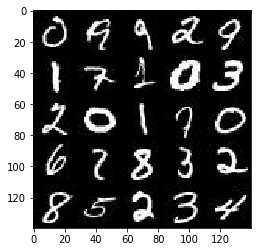

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

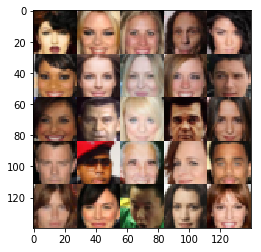

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_images')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input_images, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [94]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        x = tf.maximum(x, alpha * x)
        # 14*14*64
        
        x = tf.layers.conv2d(x, 128, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x, alpha * x)
        # 7*7*128
        
        x = tf.reshape(x, (-1, 7 * 7 * 128))
        
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [95]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 7 * 7 * 512)

        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x, alpha * x)
        # 7x7x512
        
        x = tf.layers.conv2d_transpose(x, 128, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x, alpha * x)
        # 14x14x128

        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 8, strides=2, padding='same')

        out = tf.tanh(logits)

        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [96]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [97]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [98]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [99]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data (n_images, width, height, image_channels)
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    total_images, image_width, image_height, image_channels = data_shape

    # Build network
    real_inputs, z_inputs, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_inputs, image_channels, alpha=alpha)

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    n_batches = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                n_batches += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt,
                             feed_dict={real_inputs: batch_images, z_inputs: batch_z, lr: learning_rate})
                _ = sess.run(g_opt,
                             feed_dict={z_inputs: batch_z, real_inputs: batch_images, lr: learning_rate})

                if n_batches % print_every == 0:
                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if n_batches % show_every == 0:
                    show_generator_output(sess, 25, z_inputs, image_channels, data_image_mode)
        print("Result for trained generator:")
        show_generator_output(sess, 25, z_inputs, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.1730... Generator Loss: 0.0802
Epoch 1/2... Discriminator Loss: 2.4550... Generator Loss: 0.1983
Epoch 1/2... Discriminator Loss: 2.2086... Generator Loss: 0.4240
Epoch 1/2... Discriminator Loss: 1.8838... Generator Loss: 0.5238
Epoch 1/2... Discriminator Loss: 1.8047... Generator Loss: 0.4787
Epoch 1/2... Discriminator Loss: 1.6184... Generator Loss: 0.5701
Epoch 1/2... Discriminator Loss: 1.3989... Generator Loss: 0.6535
Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 0.7705
Epoch 1/2... Discriminator Loss: 1.1600... Generator Loss: 0.8150
Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 0.9753


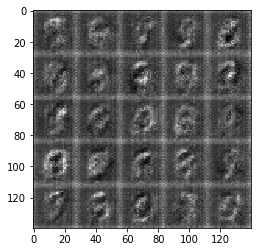

Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 0.9597
Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 1.0439
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 0.8418
Epoch 1/2... Discriminator Loss: 0.9287... Generator Loss: 1.5129
Epoch 1/2... Discriminator Loss: 0.9206... Generator Loss: 1.1403
Epoch 1/2... Discriminator Loss: 0.8070... Generator Loss: 0.9997
Epoch 1/2... Discriminator Loss: 0.7583... Generator Loss: 1.0017
Epoch 1/2... Discriminator Loss: 0.8094... Generator Loss: 1.0629
Epoch 1/2... Discriminator Loss: 0.6531... Generator Loss: 1.4529
Epoch 1/2... Discriminator Loss: 0.6732... Generator Loss: 1.4604


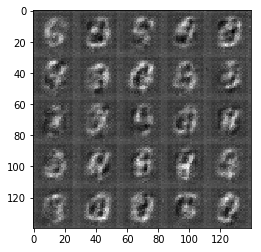

Epoch 1/2... Discriminator Loss: 0.9396... Generator Loss: 0.6759
Epoch 1/2... Discriminator Loss: 0.7517... Generator Loss: 0.9246
Epoch 1/2... Discriminator Loss: 0.6920... Generator Loss: 1.2509
Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 1.0209
Epoch 1/2... Discriminator Loss: 0.7007... Generator Loss: 1.1084
Epoch 1/2... Discriminator Loss: 0.7046... Generator Loss: 1.0672
Epoch 1/2... Discriminator Loss: 0.6074... Generator Loss: 1.6106
Epoch 1/2... Discriminator Loss: 0.6746... Generator Loss: 1.0958
Epoch 1/2... Discriminator Loss: 0.6938... Generator Loss: 1.7775
Epoch 1/2... Discriminator Loss: 0.6393... Generator Loss: 1.3723


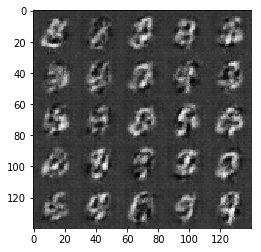

Epoch 1/2... Discriminator Loss: 0.5197... Generator Loss: 1.4552
Epoch 1/2... Discriminator Loss: 0.4722... Generator Loss: 1.7662
Epoch 1/2... Discriminator Loss: 0.6681... Generator Loss: 0.9846
Epoch 1/2... Discriminator Loss: 0.6476... Generator Loss: 1.0045
Epoch 1/2... Discriminator Loss: 0.4990... Generator Loss: 1.4503
Epoch 1/2... Discriminator Loss: 0.5540... Generator Loss: 1.3247
Epoch 1/2... Discriminator Loss: 0.4380... Generator Loss: 1.5770
Epoch 1/2... Discriminator Loss: 0.4780... Generator Loss: 1.6203
Epoch 1/2... Discriminator Loss: 0.8234... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 0.4389... Generator Loss: 1.5139


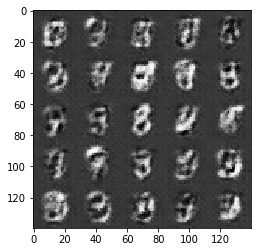

Epoch 1/2... Discriminator Loss: 0.4619... Generator Loss: 1.5517
Epoch 1/2... Discriminator Loss: 0.7656... Generator Loss: 0.7563
Epoch 1/2... Discriminator Loss: 0.3834... Generator Loss: 1.7297
Epoch 1/2... Discriminator Loss: 0.5022... Generator Loss: 2.3341
Epoch 1/2... Discriminator Loss: 0.3546... Generator Loss: 1.7894
Epoch 1/2... Discriminator Loss: 0.3933... Generator Loss: 1.9721
Epoch 2/2... Discriminator Loss: 0.3445... Generator Loss: 1.7616
Epoch 2/2... Discriminator Loss: 0.3373... Generator Loss: 2.2655
Epoch 2/2... Discriminator Loss: 0.4749... Generator Loss: 2.4735
Epoch 2/2... Discriminator Loss: 0.3621... Generator Loss: 1.9929


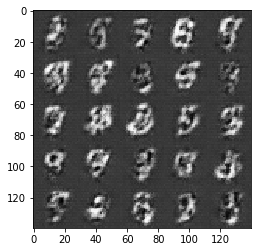

Epoch 2/2... Discriminator Loss: 0.3588... Generator Loss: 1.6419
Epoch 2/2... Discriminator Loss: 0.3108... Generator Loss: 2.2551
Epoch 2/2... Discriminator Loss: 0.3082... Generator Loss: 2.5091
Epoch 2/2... Discriminator Loss: 0.3103... Generator Loss: 2.0157
Epoch 2/2... Discriminator Loss: 0.2932... Generator Loss: 2.0686
Epoch 2/2... Discriminator Loss: 0.2766... Generator Loss: 2.0505
Epoch 2/2... Discriminator Loss: 0.3443... Generator Loss: 1.6388
Epoch 2/2... Discriminator Loss: 0.2515... Generator Loss: 2.0220
Epoch 2/2... Discriminator Loss: 0.2619... Generator Loss: 2.1044
Epoch 2/2... Discriminator Loss: 0.2636... Generator Loss: 2.6279


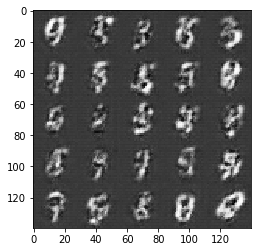

Epoch 2/2... Discriminator Loss: 0.2467... Generator Loss: 2.1347
Epoch 2/2... Discriminator Loss: 0.2689... Generator Loss: 2.5760
Epoch 2/2... Discriminator Loss: 0.2525... Generator Loss: 2.3308
Epoch 2/2... Discriminator Loss: 0.2458... Generator Loss: 1.9735
Epoch 2/2... Discriminator Loss: 0.2393... Generator Loss: 2.2537
Epoch 2/2... Discriminator Loss: 0.2348... Generator Loss: 2.1946
Epoch 2/2... Discriminator Loss: 0.2783... Generator Loss: 2.5819
Epoch 2/2... Discriminator Loss: 0.2061... Generator Loss: 2.3094
Epoch 2/2... Discriminator Loss: 0.1954... Generator Loss: 2.5122
Epoch 2/2... Discriminator Loss: 0.1915... Generator Loss: 2.4997


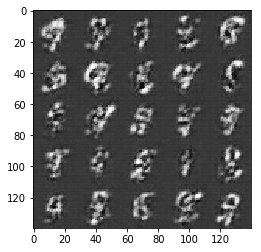

Epoch 2/2... Discriminator Loss: 0.1953... Generator Loss: 2.6989
Epoch 2/2... Discriminator Loss: 0.1849... Generator Loss: 2.5614
Epoch 2/2... Discriminator Loss: 0.2061... Generator Loss: 2.3415
Epoch 2/2... Discriminator Loss: 0.2329... Generator Loss: 3.4231
Epoch 2/2... Discriminator Loss: 0.1883... Generator Loss: 2.8708
Epoch 2/2... Discriminator Loss: 0.1992... Generator Loss: 2.4905
Epoch 2/2... Discriminator Loss: 0.1870... Generator Loss: 2.4985
Epoch 2/2... Discriminator Loss: 0.1844... Generator Loss: 2.5087
Epoch 2/2... Discriminator Loss: 0.1719... Generator Loss: 2.5515
Epoch 2/2... Discriminator Loss: 0.1754... Generator Loss: 3.0268


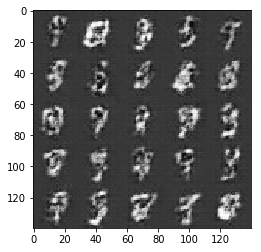

Epoch 2/2... Discriminator Loss: 0.2139... Generator Loss: 2.1113
Epoch 2/2... Discriminator Loss: 0.1931... Generator Loss: 2.2382
Epoch 2/2... Discriminator Loss: 0.1688... Generator Loss: 2.6835
Epoch 2/2... Discriminator Loss: 0.1549... Generator Loss: 2.8786
Epoch 2/2... Discriminator Loss: 0.1467... Generator Loss: 2.7027
Epoch 2/2... Discriminator Loss: 0.1546... Generator Loss: 2.6903
Epoch 2/2... Discriminator Loss: 0.1781... Generator Loss: 2.6070
Epoch 2/2... Discriminator Loss: 0.1566... Generator Loss: 2.7457
Epoch 2/2... Discriminator Loss: 0.1500... Generator Loss: 2.7192
Epoch 2/2... Discriminator Loss: 0.1384... Generator Loss: 2.9827


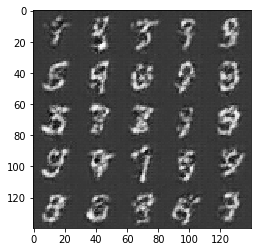

Epoch 2/2... Discriminator Loss: 0.1548... Generator Loss: 2.6291
Epoch 2/2... Discriminator Loss: 0.1584... Generator Loss: 2.7264
Epoch 2/2... Discriminator Loss: 0.1530... Generator Loss: 3.5080
Result for trained generator:


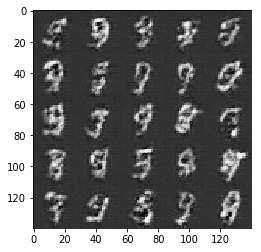

In [100]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.6820... Generator Loss: 0.0170
Epoch 1/1... Discriminator Loss: 4.6726... Generator Loss: 0.0261
Epoch 1/1... Discriminator Loss: 3.2397... Generator Loss: 0.1425
Epoch 1/1... Discriminator Loss: 3.1128... Generator Loss: 0.1949
Epoch 1/1... Discriminator Loss: 2.9156... Generator Loss: 0.2861
Epoch 1/1... Discriminator Loss: 2.4376... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 1.9158... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7528


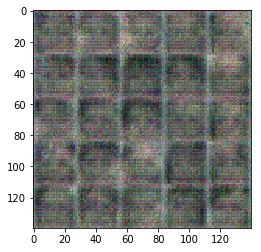

Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 0.5535... Generator Loss: 1.9933
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 0.5323... Generator Loss: 1.8514
Epoch 1/1... Discriminator Loss: 1.6227... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.8715... Generator Loss: 0.2133


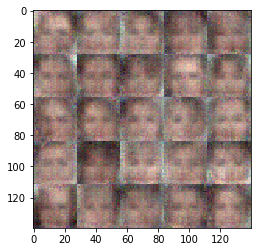

Epoch 1/1... Discriminator Loss: 1.6816... Generator Loss: 0.3077
Epoch 1/1... Discriminator Loss: 0.7562... Generator Loss: 1.3640
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 2.8268
Epoch 1/1... Discriminator Loss: 0.5372... Generator Loss: 5.1364
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 10.0113
Epoch 1/1... Discriminator Loss: 1.6782... Generator Loss: 0.3171
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 2.4762
Epoch 1/1... Discriminator Loss: 1.5676... Generator Loss: 0.3802


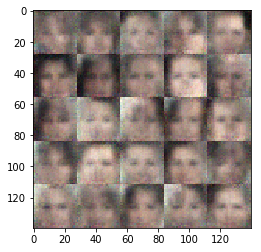

Epoch 1/1... Discriminator Loss: 0.6202... Generator Loss: 1.6011
Epoch 1/1... Discriminator Loss: 0.2053... Generator Loss: 9.8083
Epoch 1/1... Discriminator Loss: 0.2611... Generator Loss: 3.4476
Epoch 1/1... Discriminator Loss: 1.6388... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 0.3352... Generator Loss: 2.3444
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 8.7584
Epoch 1/1... Discriminator Loss: 1.6308... Generator Loss: 0.2824
Epoch 1/1... Discriminator Loss: 0.3772... Generator Loss: 7.5559
Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 4.4785
Epoch 1/1... Discriminator Loss: 0.3482... Generator Loss: 8.1387


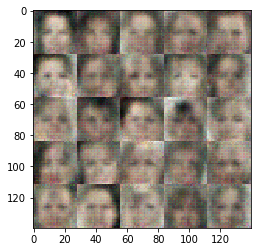

Epoch 1/1... Discriminator Loss: 1.6374... Generator Loss: 0.3082
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 3.7773
Epoch 1/1... Discriminator Loss: 0.3203... Generator Loss: 5.7319
Epoch 1/1... Discriminator Loss: 1.7622... Generator Loss: 0.2520
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 1.8502
Epoch 1/1... Discriminator Loss: 0.4269... Generator Loss: 5.5627
Epoch 1/1... Discriminator Loss: 1.7702... Generator Loss: 0.2529
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 2.2549
Epoch 1/1... Discriminator Loss: 0.4566... Generator Loss: 5.5252
Epoch 1/1... Discriminator Loss: 1.7727... Generator Loss: 0.2638


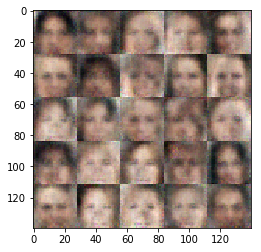

Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 2.0995
Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 5.5988
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.3643
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.8044... Generator Loss: 0.2472
Epoch 1/1... Discriminator Loss: 0.2583... Generator Loss: 5.5894
Epoch 1/1... Discriminator Loss: 1.8490... Generator Loss: 0.2237
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 1.9174
Epoch 1/1... Discriminator Loss: 0.4156... Generator Loss: 2.0961
Epoch 1/1... Discriminator Loss: 0.2303... Generator Loss: 3.2857


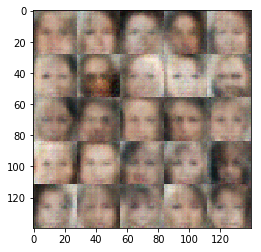

Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.3698
Epoch 1/1... Discriminator Loss: 1.5706... Generator Loss: 0.2906
Epoch 1/1... Discriminator Loss: 0.7796... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 5.9508
Epoch 1/1... Discriminator Loss: 0.6762... Generator Loss: 1.4518
Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 2.9981
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 0.2415... Generator Loss: 9.4996
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 0.5598... Generator Loss: 1.8451


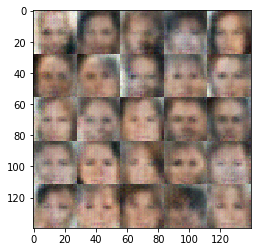

Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 0.3776... Generator Loss: 2.0884
Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 3.8657
Epoch 1/1... Discriminator Loss: 0.4722... Generator Loss: 4.2814
Epoch 1/1... Discriminator Loss: 0.3566... Generator Loss: 2.6230
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 2.5282
Epoch 1/1... Discriminator Loss: 0.3688... Generator Loss: 7.1196
Epoch 1/1... Discriminator Loss: 0.6178... Generator Loss: 5.3306
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 0.8879


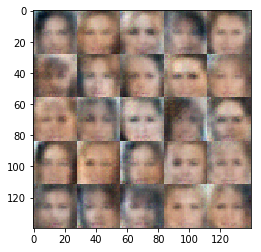

Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.3524
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 6.0323
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 0.6653... Generator Loss: 2.3089
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 4.4154
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 0.4173... Generator Loss: 2.8755
Epoch 1/1... Discriminator Loss: 0.2927... Generator Loss: 3.4955


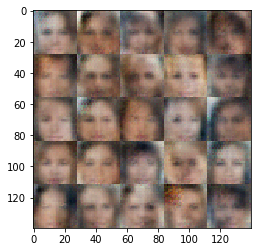

Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.5193
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.3867
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 1.3891
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 0.4075... Generator Loss: 3.4495
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 0.3944... Generator Loss: 3.0043
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.6945
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.6274


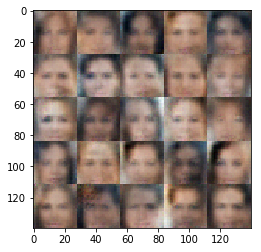

Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 3.3913
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 1.2498
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 1.5665
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.4181
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.3515
Epoch 1/1... Discriminator Loss: 0.3216... Generator Loss: 3.0787
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 2.7533
Epoch 1/1... Discriminator Loss: 0.5658... Generator Loss: 3.0792


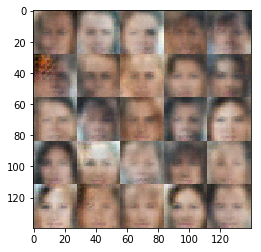

Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 2.7910
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 0.3154... Generator Loss: 2.7512
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 1.6419
Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 3.3886
Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 0.3699... Generator Loss: 2.4063
Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 0.6778... Generator Loss: 0.9969


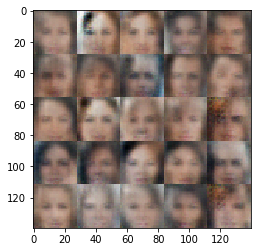

Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 1.9735
Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 0.3986... Generator Loss: 1.8238
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 2.8958
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 0.2322... Generator Loss: 3.8917
Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 2.4280
Epoch 1/1... Discriminator Loss: 0.3534... Generator Loss: 3.1122
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 3.1389


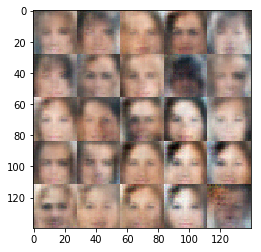

Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 0.2671... Generator Loss: 4.6999
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 3.6758
Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 1.7753
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 1.4644
Epoch 1/1... Discriminator Loss: 0.4338... Generator Loss: 2.3258
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.9570
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 0.9666


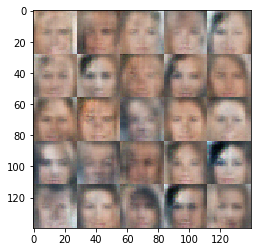

Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 3.1910
Epoch 1/1... Discriminator Loss: 0.5173... Generator Loss: 1.5493
Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 1.8503
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 2.4316
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 0.7038... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 0.4516... Generator Loss: 2.4759
Epoch 1/1... Discriminator Loss: 0.6069... Generator Loss: 1.2853
Epoch 1/1... Discriminator Loss: 0.2525... Generator Loss: 3.1724
Epoch 1/1... Discriminator Loss: 0.4810... Generator Loss: 1.3038


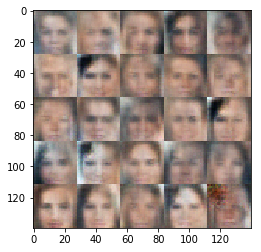

Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 2.8276
Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 2.2072
Epoch 1/1... Discriminator Loss: 0.3232... Generator Loss: 3.3689
Epoch 1/1... Discriminator Loss: 0.5280... Generator Loss: 1.3837
Epoch 1/1... Discriminator Loss: 2.2507... Generator Loss: 0.3064
Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 1.2683
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 1.6357
Result for trained generator:


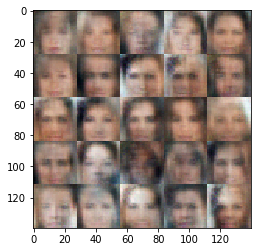

In [101]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.